<a href="https://colab.research.google.com/github/SaumyaGupta-99/Text-to-Image-Using-GANs/blob/main/DM_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting the drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# %cd "/content/gdrive/My Drive/Saumya/output/Model"
# !wget https://drive.google.com/u/0/uc?id=1BmDKqIyNY_7XWhXpxa2gm6TYxB2DQHS3&export=download

Configuration Values

In [ ]:
DATASET_NAME = 'birds'
CONFIG_NAME = ''
DATA_DIR = '/content/gdrive/My Drive/Saumya'
GPU_ID = 0
CUDA = True
WORKERS = 1

RNN_TYPE = 'LSTM'   # 'GRU'
B_VALIDATION = True


BRANCH_NUM = 3
BASE_SIZE = 64

# Training options
BATCH_SIZE = 10
MAX_EPOCH = 800
SNAPSHOT_INTERVAL = 25
DISCRIMINATOR_LR = 0.0002
GENERATOR_LR = 0.0002
ENCODER_LR =0.002
RNN_GRAD_CLIP = 0.25
FLAG = False
NET_E = '/content/gdrive/My Drive/Saumya/output/text_encoder200.pth'
NET_G = '/content/gdrive/My Drive/Saumya/output/Model/DM-GAN/bird_DMGAN.pth'
B_NET_D = True


GAMMA1 = 4.0
GAMMA3 = 10.0
GAMMA2 = 5.0
LAMBDA = 5.0


# Modal options

DF_DIM =32
GF_DIM = 64
Z_DIM = 100
CONDITION_DIM = 100
R_NUM = 2
B_ATTENTION = True
B_DCGAN = False



CAPTIONS_PER_IMAGE = 10
EMBEDDING_DIM = 256
WORDS_NUM = 25

Global Attention

In [ ]:
import torch
import torch.nn as nn

def conv1x1(in_planes, out_planes):
    "1x1 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1,
                     padding=0, bias=False)


def func_attention(query, context, gamma1):
    """
    query: batch x ndf x queryL
    context: batch x ndf x ih x iw (sourceL=ihxiw)
    mask: batch_size x sourceL
    """
    batch_size, queryL = query.size(0), query.size(2)
    ih, iw = context.size(2), context.size(3)
    sourceL = ih * iw

    # --> batch x sourceL x ndf
    context = context.view(batch_size, -1, sourceL)
    contextT = torch.transpose(context, 1, 2).contiguous()

    # Get attention
    # (batch x sourceL x ndf)(batch x ndf x queryL)
    # -->batch x sourceL x queryL
    attn = torch.bmm(contextT, query)  # Eq. (7) in AttnGAN paper
    # --> batch*sourceL x queryL
    attn = attn.view(batch_size * sourceL, queryL)
    attn = nn.Softmax()(attn)  # Eq. (8)

    # --> batch x sourceL x queryL
    attn = attn.view(batch_size, sourceL, queryL)
    # --> batch*queryL x sourceL
    attn = torch.transpose(attn, 1, 2).contiguous()
    attn = attn.view(batch_size * queryL, sourceL)
    #  Eq. (9)
    attn = attn * gamma1
    attn = nn.Softmax()(attn)
    attn = attn.view(batch_size, queryL, sourceL)
    # --> batch x sourceL x queryL
    attnT = torch.transpose(attn, 1, 2).contiguous()

    # (batch x ndf x sourceL)(batch x sourceL x queryL)
    # --> batch x ndf x queryL
    weightedContext = torch.bmm(context, attnT)

    return weightedContext, attn.view(batch_size, -1, ih, iw)


class GlobalAttentionGeneral(nn.Module):
    def __init__(self, idf, cdf):
        super(GlobalAttentionGeneral, self).__init__()
        #self.conv_context = conv1x1(cdf, idf)
        self.sm = nn.Softmax()
        self.mask = None

    def applyMask(self, mask):
        self.mask = mask  # batch x sourceL

    def forward(self, input, context_key, content_value):#
        """
            input: batch x idf x ih x iw (queryL=ihxiw)
            context: batch x cdf x sourceL
        """
        ih, iw = input.size(2), input.size(3)
        queryL = ih * iw
        batch_size, sourceL = context_key.size(0), context_key.size(2)

        # --> batch x queryL x idf
        target = input.view(batch_size, -1, queryL)
        targetT = torch.transpose(target, 1, 2).contiguous()
        # batch x cdf x sourceL --> batch x cdf x sourceL x 1
        #sourceT = context.unsqueeze(3)
        # --> batch x idf x sourceL
        #sourceT = self.conv_context(sourceT).squeeze(3)
        sourceT = context_key

        # Get attention
        # (batch x queryL x idf)(batch x idf x sourceL)
        # -->batch x queryL x sourceL
        attn = torch.bmm(targetT, sourceT)

        text_weighted = None
        # text_attn = torch.transpose(attn, 1, 2).contiguous() # batch x sourceL x queryL
        # text_attn = text_attn.view(batch_size*sourceL, queryL)
        # if self.mask is not None:
        #     mask = self.mask.repeat(queryL, 1)
        #     mask = mask.view(batch_size, queryL, sourceL)
        #     mask = torch.transpose(mask, 1, 2).contiguous()
        #     mask = mask.view(batch_size*sourceL, queryL)
        #     text_attn.data.masked_fill_(mask.data, -float('inf'))
        # text_attn = self.sm(text_attn)
        # text_attn = text_attn.view(batch_size,sourceL, queryL)
        # text_attn = torch.transpose(text_attn, 1, 2).contiguous() # batch x queryL x sourceL
        # # (batch x idf x queryL) * (batch x queryL x sourceL) -> batch x idf x sourceL
        # text_weighted = torch.bmm(target, text_attn)

        # --> batch*queryL x sourceL
        attn = attn.view(batch_size * queryL, sourceL)
        if self.mask is not None:
            # batch_size x sourceL --> batch_size*queryL x sourceL
            mask = self.mask.repeat(queryL, 1)
            attn.data.masked_fill_(mask.data, -float('inf'))
        attn = self.sm(attn)  # Eq. (2)
        # --> batch x queryL x sourceL
        attn = attn.view(batch_size, queryL, sourceL)
        # --> batch x sourceL x queryL
        attn = torch.transpose(attn, 1, 2).contiguous()

        # (batch x idf x sourceL)(batch x sourceL x queryL)
        # --> batch x idf x queryL
        weightedContext = torch.bmm(content_value, attn)  #
        #weightedContext = torch.bmm(sourceT, attn)
        weightedContext = weightedContext.view(batch_size, -1, ih, iw)
        attn = attn.view(batch_size, -1, ih, iw)

        return weightedContext, attn


class GlobalAttention_text(nn.Module):
    def __init__(self, idf, cdf):
        super(GlobalAttention_text, self).__init__()
        self.conv_context = nn.Conv1d(cdf, idf, kernel_size=1, stride=1, padding=0)
        self.sm = nn.Softmax()
        self.mask = None

    def applyMask(self, mask):
        self.mask = mask  # batch x sourceL

    def forward(self, input, context):
        """
            input: batch x idf x ih x iw (queryL=ihxiw)
            context: batch x cdf x sourceL
        """
        ih, iw = input.size(2), input.size(3)
        queryL = ih * iw
        batch_size, sourceL = context.size(0), context.size(2)

        # --> batch x queryL x idf
        target = input.view(batch_size, -1, queryL)
        targetT = torch.transpose(target, 1, 2).contiguous()
        sourceT = self.conv_context(context)

        # Get attention
        # (batch x queryL x idf)(batch x idf x sourceL)
        # -->batch x queryL x sourceL
        attn = torch.bmm(targetT, sourceT)

        # --> batch*queryL x sourceL
        attn = attn.view(batch_size * queryL, sourceL)
        if self.mask is not None:
            # batch_size x sourceL --> batch_size*queryL x sourceL
            mask = self.mask.repeat(queryL, 1)
            attn.data.masked_fill_(mask.data, -float('inf'))
        #attn_o = self.sm(attn)  # Eq. (2)
        #attn_o = attn_o.view(batch_size, queryL, sourceL)

        attn = attn.view(batch_size, queryL, sourceL)
        attn = torch.nn.Softmax(dim=1)(attn)

        #import ipdb;
        #ipdb.set_trace()  # BREAKPOINT

        # (batch x idf x queryL) * (batch x queryL x sourceL) -> batch x idf x sourceL
        text_weighted = torch.bmm(target, attn)

        return text_weighted

Losses

In [ ]:
import torch
import torch.nn as nn
import numpy as np
def cosine_similarity(x1, x2, dim=1, eps=1e-8):
    """Returns cosine similarity between x1 and x2, computed along dim.
    """
    w12 = torch.sum(x1 * x2, dim)
    w1 = torch.norm(x1, 2, dim)
    w2 = torch.norm(x2, 2, dim)
    return (w12 / (w1 * w2).clamp(min=eps)).squeeze()


def sent_loss(cnn_code, rnn_code, labels, class_ids,
              batch_size, eps=1e-8):
    masks = []
    if class_ids is not None:
        for i in range(batch_size):
            mask = (class_ids == class_ids[i]).astype(np.uint8)
            mask[i] = 0
            masks.append(mask.reshape((1, -1)))
        masks = np.concatenate(masks, 0)
        # masks: batch_size x batch_size
        masks = torch.ByteTensor(masks)
        masks = masks.cuda()

    # --> seq_len x batch_size x nef
    if cnn_code.dim() == 2:
        cnn_code = cnn_code.unsqueeze(0)
        rnn_code = rnn_code.unsqueeze(0)

    # cnn_code_norm / rnn_code_norm: seq_len x batch_size x 1
    cnn_code_norm = torch.norm(cnn_code, 2, dim=2, keepdim=True)
    rnn_code_norm = torch.norm(rnn_code, 2, dim=2, keepdim=True)
    # scores* / norm*: seq_len x batch_size x batch_size
    scores0 = torch.bmm(cnn_code, rnn_code.transpose(1, 2))
    norm0 = torch.bmm(cnn_code_norm, rnn_code_norm.transpose(1, 2))
    scores0 = scores0 / norm0.clamp(min=eps) * GAMMA3

    # --> batch_size x batch_size
    scores0 = scores0.squeeze()
    if class_ids is not None:
        scores0.data.masked_fill_(masks, -float('inf'))
    scores1 = scores0.transpose(0, 1)
    if labels is not None:
        loss0 = nn.CrossEntropyLoss()(scores0, labels)
        loss1 = nn.CrossEntropyLoss()(scores1, labels)
    else:
        loss0, loss1 = None, None
    return loss0, loss1


def words_loss(img_features, words_emb, labels,
               cap_lens, class_ids, batch_size):
    """
        words_emb(query): batch x nef x seq_len
        img_features(context): batch x nef x 17 x 17
    """
    masks = []
    att_maps = []
    similarities = []
    cap_lens = cap_lens.data.tolist()
    for i in range(batch_size):
        if class_ids is not None:
            mask = (class_ids == class_ids[i]).astype(np.uint8)
            mask[i] = 0
            masks.append(mask.reshape((1, -1)))
        # Get the i-th text description
        words_num = cap_lens[i]
        # -> 1 x nef x words_num
        word = words_emb[i, :, :words_num].unsqueeze(0).contiguous()
        # -> batch_size x nef x words_num
        word = word.repeat(batch_size, 1, 1)
        # batch x nef x 17*17
        context = img_features
        """
            word(query): batch x nef x words_num
            context: batch x nef x 17 x 17
            weiContext: batch x nef x words_num
            attn: batch x words_num x 17 x 17
        """
        weiContext, attn = func_attention(word, context, GAMMA1)
        att_maps.append(attn[i].unsqueeze(0).contiguous())
        # --> batch_size x words_num x nef
        word = word.transpose(1, 2).contiguous()
        weiContext = weiContext.transpose(1, 2).contiguous()
        # --> batch_size*words_num x nef
        word = word.view(batch_size * words_num, -1)
        weiContext = weiContext.view(batch_size * words_num, -1)
        #
        # -->batch_size*words_num
        row_sim = cosine_similarity(word, weiContext)
        # --> batch_size x words_num
        row_sim = row_sim.view(batch_size, words_num)

        # Eq. (10)
        row_sim.mul_(GAMMA2).exp_()
        row_sim = row_sim.sum(dim=1, keepdim=True)
        row_sim = torch.log(row_sim)

        # --> 1 x batch_size
        # similarities(i, j): the similarity between the i-th image and the j-th text description
        similarities.append(row_sim)

    # batch_size x batch_size
    similarities = torch.cat(similarities, 1)
    if class_ids is not None:
        masks = np.concatenate(masks, 0)
        # masks: batch_size x batch_size
        masks = torch.ByteTensor(masks)
        masks = masks.cuda()

    similarities = similarities * GAMMA3
    if class_ids is not None:
        similarities.data.masked_fill_(masks, -float('inf'))
    similarities1 = similarities.transpose(0, 1)
    if labels is not None:
        loss0 = nn.CrossEntropyLoss()(similarities, labels)
        loss1 = nn.CrossEntropyLoss()(similarities1, labels)
    else:
        loss0, loss1 = None, None
    return loss0, loss1, att_maps


# ##################Loss for G and Ds##############################
def discriminator_loss(netD, real_imgs, fake_imgs, conditions,
                       real_labels, fake_labels):
    # Forward
    real_features = netD(real_imgs)
    fake_features = netD(fake_imgs.detach())
    # loss
    #
    cond_real_logits = netD.COND_DNET(real_features, conditions)
    cond_real_errD = nn.BCELoss()(cond_real_logits, real_labels)
    cond_fake_logits = netD.COND_DNET(fake_features, conditions)
    cond_fake_errD = nn.BCELoss()(cond_fake_logits, fake_labels)
    #
    batch_size = real_features.size(0)
    cond_wrong_logits = netD.COND_DNET(real_features[:(batch_size - 1)], conditions[1:batch_size])
    cond_wrong_errD = nn.BCELoss()(cond_wrong_logits, fake_labels[1:batch_size])

    if netD.UNCOND_DNET is not None:
        real_logits = netD.UNCOND_DNET(real_features)
        fake_logits = netD.UNCOND_DNET(fake_features)
        real_errD = nn.BCELoss()(real_logits, real_labels)
        fake_errD = nn.BCELoss()(fake_logits, fake_labels)
        errD = ((real_errD + cond_real_errD) / 2. +
                (fake_errD + cond_fake_errD + cond_wrong_errD) / 3.)
    else:
        errD = cond_real_errD + (cond_fake_errD + cond_wrong_errD) / 2.
    log = 'Real_Acc: {:.4f} Fake_Acc: {:.4f} '.format(torch.mean(real_logits).item(), torch.mean(fake_logits).item())
    return errD, log


def generator_loss(netsD, image_encoder, fake_imgs, real_labels,
                   words_embs, sent_emb, match_labels,
                   cap_lens, class_ids):
    numDs = len(netsD)
    batch_size = real_labels.size(0)
    logs = ''
    # Forward
    errG_total = 0
    for i in range(numDs):
        features = netsD[i](fake_imgs[i])
        cond_logits = netsD[i].COND_DNET(features, sent_emb)
        cond_errG = nn.BCELoss()(cond_logits, real_labels)
        if netsD[i].UNCOND_DNET is  not None:
            logits = netsD[i].UNCOND_DNET(features)
            errG = nn.BCELoss()(logits, real_labels)
            g_loss = errG + cond_errG
        else:
            g_loss = cond_errG
        errG_total += g_loss
       
        logs += 'g_loss%d: %.2f ' % (i, g_loss.item())

        # Ranking loss
        if i == (numDs - 1):
            # words_features: batch_size x nef x 17 x 17
            # sent_code: batch_size x nef
            region_features, cnn_code = image_encoder(fake_imgs[i])
            w_loss0, w_loss1, _ = words_loss(region_features, words_embs,
                                             match_labels, cap_lens,
                                             class_ids, batch_size)
            w_loss = (w_loss0 + w_loss1) * LAMBDA
          

            s_loss0, s_loss1 = sent_loss(cnn_code, sent_emb,
                                         match_labels, class_ids, batch_size)
            s_loss = (s_loss0 + s_loss1) * LAMBDA

            errG_total += w_loss + s_loss
            logs += 'w_loss: %.2f s_loss: %.2f ' % (w_loss.item(), s_loss.item())
    return errG_total, logs


##################################################################
def KL_loss(mu, logvar):
    # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.mean(KLD_element).mul_(-0.5)
    return KLD

Utility Functions

In [ ]:
import os
import errno
import numpy as np
from torch.nn import init

import torch
import torch.nn as nn

from PIL import Image, ImageDraw, ImageFont
from copy import deepcopy
import skimage.transform
COLOR_DIC = {0:[128,64,128],  1:[244, 35,232],
             2:[70, 70, 70],  3:[102,102,156],
             4:[190,153,153], 5:[153,153,153],
             6:[250,170, 30], 7:[220, 220, 0],
             8:[107,142, 35], 9:[152,251,152],
             10:[70,130,180], 11:[220,20, 60],
             12:[255, 0, 0],  13:[0, 0, 142],
             14:[119,11, 32], 15:[0, 60,100],
             16:[0, 80, 100], 17:[0, 0, 230],
             18:[0,  0, 70],  19:[0, 0,  0]}
FONT_MAX = 50


def drawCaption(convas, captions, ixtoword, vis_size, off1=2, off2=2):
    num = captions.size(0)
    img_txt = Image.fromarray(convas)
    # get a font
    # fnt = None  # ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 50)
    fnt = ImageFont.truetype("/content/gdrive/My Drive/Saumya/Chn_Prop_Arial_Normal.ttf",25)
    # get a drawing context
    d = ImageDraw.Draw(img_txt)
    sentence_list = []
    for i in range(num):
        cap = captions[i].data.cpu().numpy()
        sentence = []
        for j in range(len(cap)):
            if cap[j] == 0:
                break
            word = ixtoword[cap[j]].encode('ascii', 'ignore').decode('ascii')
            d.text(((j + off1) * (vis_size + off2), i * FONT_MAX), '%d:%s' % (j, word[:6]),
                   font=fnt, fill=(255, 255, 255, 255))
            sentence.append(word)
        sentence_list.append(sentence)
    return img_txt, sentence_list


def build_super_images(real_imgs, captions, ixtoword,
                       attn_maps, att_sze, lr_imgs=None,
                       batch_size=BATCH_SIZE,
                       max_word_num=WORDS_NUM):
    nvis = 8
    real_imgs = real_imgs[:nvis]
    if lr_imgs is not None:
        lr_imgs = lr_imgs[:nvis]
    if att_sze == 17:
        vis_size = att_sze * 16
    else:
        vis_size = real_imgs.size(2)

    text_convas = \
        np.ones([batch_size * FONT_MAX,
                 (max_word_num + 2) * (vis_size + 2), 3],
                dtype=np.uint8)

    for i in range(max_word_num):
        istart = (i + 2) * (vis_size + 2)
        iend = (i + 3) * (vis_size + 2)
        text_convas[:, istart:iend, :] = COLOR_DIC[i]


    real_imgs = \
        nn.functional.interpolate(real_imgs,size=(vis_size, vis_size),
                                  mode='bilinear', align_corners=False)
    # [-1, 1] --> [0, 1]
    real_imgs.add_(1).div_(2).mul_(255)
    real_imgs = real_imgs.data.numpy()
    # b x c x h x w --> b x h x w x c
    real_imgs = np.transpose(real_imgs, (0, 2, 3, 1))
    pad_sze = real_imgs.shape
    middle_pad = np.zeros([pad_sze[2], 2, 3])
    post_pad = np.zeros([pad_sze[1], pad_sze[2], 3])
    if lr_imgs is not None:
        lr_imgs = \
            nn.functional.interpolate(lr_imgs,size=(vis_size, vis_size),
                                  mode='bilinear', align_corners=False)
        # [-1, 1] --> [0, 1]
        lr_imgs.add_(1).div_(2).mul_(255)
        lr_imgs = lr_imgs.data.numpy()
        # b x c x h x w --> b x h x w x c
        lr_imgs = np.transpose(lr_imgs, (0, 2, 3, 1))

    # batch x seq_len x 17 x 17 --> batch x 1 x 17 x 17
    seq_len = max_word_num
    img_set = []
    num = nvis  # len(attn_maps)

    text_map, sentences = \
        drawCaption(text_convas, captions, ixtoword, vis_size)
    text_map = np.asarray(text_map).astype(np.uint8)

    bUpdate = 1
    for i in range(num):
        attn = attn_maps[i].cpu().view(1, -1, att_sze, att_sze)
        # --> 1 x 1 x 17 x 17
        attn_max = attn.max(dim=1, keepdim=True)
        attn = torch.cat([attn_max[0], attn], 1)
        #
        attn = attn.view(-1, 1, att_sze, att_sze)
        attn = attn.repeat(1, 3, 1, 1).data.numpy()
        # n x c x h x w --> n x h x w x c
        attn = np.transpose(attn, (0, 2, 3, 1))
        num_attn = attn.shape[0]
        #
        img = real_imgs[i]
        if lr_imgs is None:
            lrI = img
        else:
            lrI = lr_imgs[i]
        row = [lrI, middle_pad]
        row_merge = [img, middle_pad]
        row_beforeNorm = []
        minVglobal, maxVglobal = 1, 0
        for j in range(num_attn):
            one_map = attn[j]
            if (vis_size // att_sze) > 1:
                one_map = \
                    skimage.transform.pyramid_expand(one_map, sigma=20,
                                                     upscale=vis_size // att_sze,
                                                     multichannel=True)
            row_beforeNorm.append(one_map)
            minV = one_map.min()
            maxV = one_map.max()
            if minVglobal > minV:
                minVglobal = minV
            if maxVglobal < maxV:
                maxVglobal = maxV
        for j in range(seq_len + 1):
            if j < num_attn:
                one_map = row_beforeNorm[j]
                one_map = (one_map - minVglobal) / (maxVglobal - minVglobal)
                one_map *= 255
                #
                PIL_im = Image.fromarray(np.uint8(img))
                PIL_att = Image.fromarray(np.uint8(one_map))
                merged = \
                    Image.new('RGBA', (vis_size, vis_size), (0, 0, 0, 0))
                mask = Image.new('L', (vis_size, vis_size), (210))
                merged.paste(PIL_im, (0, 0))
                merged.paste(PIL_att, (0, 0), mask)
                merged = np.array(merged)[:, :, :3]
            else:
                one_map = post_pad
                merged = post_pad
            row.append(one_map)
            row.append(middle_pad)
            #
            row_merge.append(merged)
            row_merge.append(middle_pad)
        row = np.concatenate(row, 1)
        row_merge = np.concatenate(row_merge, 1)
        txt = text_map[i * FONT_MAX: (i + 1) * FONT_MAX]
        if txt.shape[1] != row.shape[1]:
            print('txt', txt.shape, 'row', row.shape)
            bUpdate = 0
            break
        row = np.concatenate([txt, row, row_merge], 0)
        img_set.append(row)
    if bUpdate:
        img_set = np.concatenate(img_set, 0)
        img_set = img_set.astype(np.uint8)
        return img_set, sentences
    else:
        return None



def build_super_images2(real_imgs, captions, cap_lens, ixtoword,
                        attn_maps, att_sze, vis_size=256, topK=5):
    batch_size = real_imgs.size(0)
    max_word_num = np.max(cap_lens)
    text_convas = np.ones([batch_size * FONT_MAX,
                           max_word_num * (vis_size + 2), 3],
                           dtype=np.uint8)

    real_imgs = \
        nn.functional.interpolate(real_imgs,size=(vis_size, vis_size),
                                    mode='bilinear', align_corners=False)
    # [-1, 1] --> [0, 1]
    real_imgs.add_(1).div_(2).mul_(255)
    real_imgs = real_imgs.data.numpy()
    # b x c x h x w --> b x h x w x c
    real_imgs = np.transpose(real_imgs, (0, 2, 3, 1))
    pad_sze = real_imgs.shape
    middle_pad = np.zeros([pad_sze[2], 2, 3])

    # batch x seq_len x 17 x 17 --> batch x 1 x 17 x 17
    img_set = []
    num = len(attn_maps)

    text_map, sentences = \
        drawCaption(text_convas, captions, ixtoword, vis_size, off1=0)
    text_map = np.asarray(text_map).astype(np.uint8)

    bUpdate = 1
    for i in range(num):
        attn = attn_maps[i].cpu().view(1, -1, att_sze, att_sze)
        #
        attn = attn.view(-1, 1, att_sze, att_sze)
        attn = attn.repeat(1, 3, 1, 1).data.numpy()
        # n x c x h x w --> n x h x w x c
        attn = np.transpose(attn, (0, 2, 3, 1))
        num_attn = cap_lens[i]
        thresh = 2./float(num_attn)
        #
        img = real_imgs[i]
        row = []
        row_merge = []
        row_txt = []
        row_beforeNorm = []
        conf_score = []
        for j in range(num_attn):
            one_map = attn[j]
            mask0 = one_map > (2. * thresh)
            conf_score.append(np.sum(one_map * mask0))
            mask = one_map > thresh
            one_map = one_map * mask
            if (vis_size // att_sze) > 1:
                one_map = \
                    skimage.transform.pyramid_expand(one_map, sigma=20,
                                                     upscale=vis_size // att_sze,
                                                     multichannel=True)
            minV = one_map.min()
            maxV = one_map.max()
            one_map = (one_map - minV) / (maxV - minV)
            row_beforeNorm.append(one_map)
        sorted_indices = np.argsort(conf_score)[::-1]

        for j in range(num_attn):
            one_map = row_beforeNorm[j]
            one_map *= 255
            #
            PIL_im = Image.fromarray(np.uint8(img))
            PIL_att = Image.fromarray(np.uint8(one_map))
            merged = \
                Image.new('RGBA', (vis_size, vis_size), (0, 0, 0, 0))
            mask = Image.new('L', (vis_size, vis_size), (180))  # (210)
            merged.paste(PIL_im, (0, 0))
            merged.paste(PIL_att, (0, 0), mask)
            merged = np.array(merged)[:, :, :3]

            row.append(np.concatenate([one_map, middle_pad], 1))
            #
            row_merge.append(np.concatenate([merged, middle_pad], 1))
            #
            txt = text_map[i * FONT_MAX:(i + 1) * FONT_MAX,
                           j * (vis_size + 2):(j + 1) * (vis_size + 2), :]
            row_txt.append(txt)
        # reorder
        row_new = []
        row_merge_new = []
        txt_new = []
        for j in range(num_attn):
            idx = sorted_indices[j]
            row_new.append(row[idx])
            row_merge_new.append(row_merge[idx])
            txt_new.append(row_txt[idx])
        row = np.concatenate(row_new[:topK], 1)
        row_merge = np.concatenate(row_merge_new[:topK], 1)
        txt = np.concatenate(txt_new[:topK], 1)
        if txt.shape[1] != row.shape[1]:
            print('Warnings: txt', txt.shape, 'row', row.shape,
                  'row_merge_new', row_merge_new.shape)
            bUpdate = 0
            break
        row = np.concatenate([txt, row_merge], 0)
        img_set.append(row)
    if bUpdate:
        img_set = np.concatenate(img_set, 0)
        img_set = img_set.astype(np.uint8)
        return img_set, sentences
    else:
        return None


####################################################################
def weights_init(m):
    # orthogonal_
    # xavier_uniform_(
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        if m.state_dict().keys() == 'weight':
            nn.init.orthogonal_(m.weight.data, 1.0)
        elif m.state_dict().keys() == 'weight_bar':
            nn.init.orthogonal_(m.weight_bar.data, 1.0)
        #nn.init.orthogonal(m.weight.data, 1.0)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        nn.init.orthogonal_(m.weight.data, 1.0)
        if m.bias is not None:
            m.bias.data.fill_(0.0)


def load_params(model, new_param):
    for p, new_p in zip(model.parameters(), new_param):
        p.data.copy_(new_p)


def copy_G_params(model):
    flatten = deepcopy(list(p.data for p in model.parameters()))
    return flatten


def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

Basic Preprocessing

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals


from nltk.tokenize import RegexpTokenizer
from collections import defaultdict


import torch
import torch.utils.data as data
from torch.autograd import Variable
import torchvision.transforms as transforms

import os
import sys
import numpy as np
import pandas as pd
from PIL import Image
import numpy.random as random
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

data_dir=DATA_DIR
def prepare_data(data):
    imgs, captions, captions_lens, class_ids, keys = data

    # sort data by the length in a decreasing order
    sorted_cap_lens, sorted_cap_indices =torch.sort(captions_lens, 0, True)

    real_imgs = []
    for i in range(len(imgs)):
        imgs[i] = imgs[i][sorted_cap_indices]
        real_imgs.append(Variable(imgs[i]).cuda())

    captions = captions[sorted_cap_indices].squeeze()
    class_ids = class_ids[sorted_cap_indices].numpy()
    # sent_indices = sent_indices[sorted_cap_indices]
    keys = [keys[i] for i in sorted_cap_indices.numpy()]
    # print('keys', type(keys), keys[-1])  # list
    captions = Variable(captions).cuda()
    sorted_cap_lens = Variable(sorted_cap_lens).cuda()

    return [real_imgs, captions, sorted_cap_lens,
            class_ids, keys]


def get_imgs(img_path, imsize, bbox=None,
             transform=None, normalize=None):
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    if bbox is not None:
        r = int(np.maximum(bbox[2], bbox[3]) * 0.75)
        center_x = int((2 * bbox[0] + bbox[2]) / 2)
        center_y = int((2 * bbox[1] + bbox[3]) / 2)
        y1 = np.maximum(0, center_y - r)
        y2 = np.minimum(height, center_y + r)
        x1 = np.maximum(0, center_x - r)
        x2 = np.minimum(width, center_x + r)
        img = img.crop([x1, y1, x2, y2])

    if transform is not None:
        img = transform(img)

    ret = []
    if B_DCGAN:
      ret = [normalize(img)]
    else:
        for i in range(BRANCH_NUM):
            # print(imsize[i])
            if i < (BRANCH_NUM - 1):
                re_img = transforms.Scale(imsize[i])(img)
            else:
                re_img = img
            ret.append(normalize(re_img))

    return ret


class TextDataset(data.Dataset):
    def __init__(self, data_dir, split='train',
                 base_size=64,
                 transform=None, target_transform=None):
        self.transform = transform
        self.norm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.target_transform = target_transform
        self.embeddings_num = CAPTIONS_PER_IMAGE

        self.imsize = []
        for i in range(BRANCH_NUM):
            self.imsize.append(base_size)
            base_size = base_size * 2

        self.data = []
        self.data_dir = data_dir
        self.bbox = self.load_bbox()
        split_dir ='/content/gdrive/My Drive/Saumya/birds/birds/%s' %(split)
        print(split_dir)
        self.filenames, self.captions, self.ixtoword,self.wordtoix, self.n_words = self.load_text_data(data_dir, split)
        self.class_id = self.load_class_id(split, len(self.filenames))
        self.number_example = len(self.filenames)-1

    def load_bbox(self):
        data_dir = self.data_dir
        bbox_path = '/content/gdrive/My Drive/Saumya/bounding_boxes.txt'
        df_bounding_boxes = pd.read_csv(bbox_path,delim_whitespace=True,header=None).astype(int)
        filepath = '/content/gdrive/My Drive/Saumya/images.txt'
        df_filenames = pd.read_csv(filepath, delim_whitespace=True, header=None)
        filenames = df_filenames[1].tolist()
        print('Total filenames: ', len(filenames), filenames[0])
        filename_bbox = {img_file[:-4]: [] for img_file in filenames}
        numImgs = len(filenames)
        for i in range(0, numImgs):
            bbox = df_bounding_boxes.iloc[i][1:].tolist()
            key = filenames[i][:-4]
            filename_bbox[key] = bbox
        return filename_bbox

    def load_captions(self, data_dir, filenames):
        all_captions = []
        for i in range(len(filenames)):
            cap_path = '%s/birds/birds/text/%s.txt' % (data_dir, filenames[i])
            with open(cap_path, "r") as f:
                captions = f.read().decode('utf8').split('\n')
                cnt = 0
                for cap in captions:
                    if len(cap) == 0:
                        continue
                    cap = cap.replace("\ufffd\ufffd", " ")
                    # picks out sequences of alphanumeric characters as tokens
                    # and drops everything else
                    tokenizer = RegexpTokenizer(r'\w+')
                    tokens = tokenizer.tokenize(cap.lower())
                    # print('tokens', tokens)
                    if len(tokens) == 0:
                        print('cap', cap)
                        continue

                    tokens_new = []
                    for t in tokens:
                        t = t.encode('ascii', 'ignore').decode('ascii')
                        if len(t) > 0:
                            tokens_new.append(t)
                    all_captions.append(tokens_new)
                    cnt += 1
                    if cnt == self.embeddings_num:
                        break
                if cnt < self.embeddings_num:
                    print('ERROR: the captions for %s less than %d'
                          % (filenames[i], cnt))
        return all_captions

    def build_dictionary(self, train_captions, test_captions):
        word_counts = defaultdict(float)
        captions = train_captions + test_captions
        for sent in captions:
            for word in sent:
                word_counts[word] += 1

        vocab = [w for w in word_counts if word_counts[w] >= 0]

        ixtoword = {}
        ixtoword[0] = '<end>'
        wordtoix = {}
        wordtoix['<end>'] = 0
        ix = 1
        for w in vocab:
            wordtoix[w] = ix
            ixtoword[ix] = w
            ix += 1

        train_captions_new = []
        for t in train_captions:
            rev = []
            for w in t:
                if w in wordtoix:
                    rev.append(wordtoix[w])
            # rev.append(0)  # do not need '<end>' token
            train_captions_new.append(rev)

        test_captions_new = []
        for t in test_captions:
            rev = []
            for w in t:
                if w in wordtoix:
                    rev.append(wordtoix[w])
            # rev.append(0)  # do not need '<end>' token
            test_captions_new.append(rev)

        return [train_captions_new, test_captions_new,
                ixtoword, wordtoix, len(ixtoword)]

    def load_text_data(self, data_dir, split):
        filepath = '/content/gdrive/My Drive/Saumya/birds/birds/captions.pickle'
        train_names = self.load_filenames('/content/gdrive/My Drive/Saumya/birds/birds', 'train')
        test_names = self.load_filenames('/content/gdrive/My Drive/Saumya/birds/birds','test')
        if not os.path.isfile(filepath):
            train_captions = self.load_captions(data_dir,train_names)
            test_captions = self.load_captions(data_dir,test_names)

            train_captions, test_captions, ixtoword, wordtoix, n_words = self.build_dictionary(train_captions, test_captions)
            with open(filepath, 'wb') as f:
                pickle.dump([train_captions, test_captions,
                             ixtoword, wordtoix], f, protocol=2)
                print('Save to: ', filepath)
        else:
            with open(filepath, 'rb') as f:
                x = pickle.load(f,encoding="latin1")
                train_captions, test_captions = x[0], x[1]
                ixtoword, wordtoix = x[2], x[3]
                del x
                n_words = len(ixtoword)
                print('Load from: ', filepath)
        if split == 'train':
            captions = train_captions
            filenames = train_names
        else:
            captions = test_captions
            filenames = test_names
        return filenames, captions, ixtoword, wordtoix, n_words

    def load_class_id(self,split, total_num):
        if os.path.isfile('/content/gdrive/My Drive/Saumya/birds/birds/%s/class_info.pickle' %(split)):
            with open('/content/gdrive/My Drive/Saumya/birds/birds/%s/class_info.pickle' %(split), 'rb') as f:
                class_id = pickle.load(f,encoding="latin1")
        else:
            class_id = np.arange(total_num)
        return class_id


    def load_filenames(self, data_dir, split):
        filepath = '%s/%s/filenames.pickle' % (data_dir, split)
        if os.path.isfile(filepath):
            with open(filepath, 'rb') as f:
                filenames = pickle.load(f,encoding='latin1')
            print('Load filenames from: %s (%d)' % (filepath, len(filenames)))
        else:
            filenames = []
        return filenames

    def get_caption(self, sent_ix):
        sent_caption = np.asarray(self.captions[sent_ix]).astype('int64')
        if (sent_caption == 0).sum() > 0:
            print('ERROR: do not need END (0) token', sent_caption)
        num_words = len(sent_caption)
        x = np.zeros((WORDS_NUM, 1), dtype='int64')
        x_len = num_words
        if num_words <= WORDS_NUM:
            x[:num_words, 0] = sent_caption
        else:
            ix = list(np.arange(num_words))
            np.random.shuffle(ix)
            ix = ix[:WORDS_NUM]
            ix = np.sort(ix)
            x[:, 0] = sent_caption[ix]
            x_len = WORDS_NUM
        return x, x_len

    def __getitem__(self, index):
        #
        key = self.filenames[index]
        cls_id = self.class_id[index]
        if self.bbox is not None:
            bbox = self.bbox[key]
            data_dir = '%s/' % self.data_dir
        else:
            bbox = None
            data_dir = self.data_dir
        #
        img_name = '%s/images/%s.jpg' % ('/content/gdrive/My Drive/Saumya', key)
        imgs = get_imgs(img_name, self.imsize,bbox, self.transform, normalize=self.norm)
        # random select a sentence
        sent_ix = random.randint(0, self.embeddings_num)
        new_sent_ix = index * self.embeddings_num + sent_ix
        caps, cap_len = self.get_caption(new_sent_ix)
        return imgs, caps, cap_len, cls_id, key

    def get_mis_caption(self, cls_id):
        mis_match_captions_t = []
        mis_match_captions = torch.zeros(99,WORDS_NUM)
        mis_match_captions_len = torch.zeros(99)
        i = 0
        while len(mis_match_captions_t) < 99:
            idx = random.randint(0, self.number_example)
            if cls_id == self.class_id[idx]:
                continue
            sent_ix = random.randint(0, self.embeddings_num-1)
            new_sent_ix = idx * self.embeddings_num + sent_ix
            caps_t, cap_len_t = self.get_caption(new_sent_ix)
            mis_match_captions_t.append(torch.from_numpy(caps_t).squeeze())
            mis_match_captions_len[i] = cap_len_t
            i = i +1
        sorted_cap_lens, sorted_cap_indices = torch.sort(mis_match_captions_len, 0, True)
        for i in range(99):
            mis_match_captions[i,:] = mis_match_captions_t[sorted_cap_indices[i]]
        return mis_match_captions.type(torch.LongTensor).cuda(), sorted_cap_lens.type(torch.LongTensor).cuda()

    def __len__(self):
        return len(self.filenames)

Spectral

In [ ]:
import torch
from torch.optim.optimizer import Optimizer, required
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

Models

In [ ]:
import torch
import torch.nn as nn
import torch.nn.parallel
from torch.autograd import Variable
from torchvision import models
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class GLU(nn.Module):
    def __init__(self):
        super(GLU, self).__init__()

    def forward(self, x):
        nc = x.size(1)
        assert nc % 2 == 0, 'channels dont divide 2!'
        nc = int(nc/2)
        return x[:, :nc] * F.sigmoid(x[:, nc:])


def conv1x1(in_planes, out_planes, bias=False):
    "1x1 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=bias)


def conv3x3(in_planes, out_planes, bias=False):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=bias)


# Upsale the spatial size by a factor of 2
def upBlock(in_planes, out_planes):
    block = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        conv3x3(in_planes, out_planes * 2),
        nn.BatchNorm2d(out_planes * 2),
        GLU())
    return block


# Keep the spatial size
def Block3x3_relu(in_planes, out_planes):
    block = nn.Sequential(
        conv3x3(in_planes, out_planes * 2),
        nn.BatchNorm2d(out_planes * 2),
        GLU())
    return block


class ResBlock(nn.Module):
    def __init__(self, channel_num):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            conv3x3(channel_num, channel_num * 2),
            nn.BatchNorm2d(channel_num * 2),
            GLU(),
            conv3x3(channel_num, channel_num),
            nn.BatchNorm2d(channel_num))

    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual
        return out


# ############## Text2Image Encoder-Decoder #######
class RNN_ENCODER(nn.Module):
    def __init__(self, ntoken, ninput=300, drop_prob=0.5,
                 nhidden=128, nlayers=1, bidirectional=True):
        super(RNN_ENCODER, self).__init__()
        self.n_steps = WORDS_NUM
        self.ntoken = ntoken  # size of the dictionary
        self.ninput = ninput  # size of each embedding vector
        self.drop_prob = drop_prob  # probability of an element to be zeroed
        self.nlayers = nlayers  # Number of recurrent layers
        self.bidirectional = bidirectional
        self.rnn_type = RNN_TYPE
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
        # number of features in the hidden state
        self.nhidden = nhidden // self.num_directions

        self.define_module()
        self.init_weights()

    def define_module(self):
        self.encoder = nn.Embedding(self.ntoken, self.ninput)
        self.drop = nn.Dropout(self.drop_prob)
        if self.rnn_type == 'LSTM':
            # dropout: If non-zero, introduces a dropout layer on
            # the outputs of each RNN layer except the last layer
            self.rnn = nn.LSTM(self.ninput, self.nhidden,
                               self.nlayers, batch_first=True,
                               dropout=self.drop_prob,
                               bidirectional=self.bidirectional)
        elif self.rnn_type == 'GRU':
            self.rnn = nn.GRU(self.ninput, self.nhidden,
                              self.nlayers, batch_first=True,
                              dropout=self.drop_prob,
                              bidirectional=self.bidirectional)
        else:
            raise NotImplementedError

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        # Do not need to initialize RNN parameters, which have been initialized
        # http://pytorch.org/docs/master/_modules/torch/nn/modules/rnn.html#LSTM
        # self.decoder.weight.data.uniform_(-initrange, initrange)
        # self.decoder.bias.data.fill_(0)

    def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        if self.rnn_type == 'LSTM':
            return (Variable(weight.new(self.nlayers * self.num_directions, bsz, self.nhidden).zero_()),
                    Variable(weight.new(self.nlayers * self.num_directions, bsz, self.nhidden).zero_()))
        else:
            return Variable(weight.new(self.nlayers * self.num_directions, bsz, self.nhidden).zero_())

    def forward(self, captions, cap_lens, hidden, mask=None):
        # input: torch.LongTensor of size batch x n_steps
        # --> emb: batch x n_steps x ninput
        emb = self.drop(self.encoder(captions))
        #
        # Returns: a PackedSequence object
        cap_lens = cap_lens.data.tolist()
        emb = pack_padded_sequence(emb, cap_lens, batch_first=True)
        # #hidden and memory (num_layers * num_directions, batch, hidden_size):
        # tensor containing the initial hidden state for each element in batch.
        # #output (batch, seq_len, hidden_size * num_directions)
        # #or a PackedSequence object:
        # tensor containing output features (h_t) from the last layer of RNN
        output, hidden = self.rnn(emb, hidden)
        # PackedSequence object
        # --> (batch, seq_len, hidden_size * num_directions)
        output = pad_packed_sequence(output, batch_first=True)[0]
        # output = self.drop(output)
        # --> batch x hidden_size*num_directions x seq_len
        words_emb = output.transpose(1, 2)
        # --> batch x num_directions*hidden_size
        if self.rnn_type == 'LSTM':
            sent_emb = hidden[0].transpose(0, 1).contiguous()
        else:
            sent_emb = hidden.transpose(0, 1).contiguous()
        sent_emb = sent_emb.view(-1, self.nhidden * self.num_directions)
        return words_emb, sent_emb


class CNN_ENCODER(nn.Module):
    def __init__(self, nef):
        super(CNN_ENCODER, self).__init__()
        if FLAG:
            self.nef = nef
        else:
            self.nef = 256  # define a uniform ranker

        model = models.inception_v3()
        url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
        model.load_state_dict(model_zoo.load_url(url))
        for param in model.parameters():
            param.requires_grad = False
        print('Load pretrained model from ', url)
        # print(model)

        self.define_module(model)
        self.init_trainable_weights()

    def define_module(self, model):
        self.Conv2d_1a_3x3 = model.Conv2d_1a_3x3
        self.Conv2d_2a_3x3 = model.Conv2d_2a_3x3
        self.Conv2d_2b_3x3 = model.Conv2d_2b_3x3
        self.Conv2d_3b_1x1 = model.Conv2d_3b_1x1
        self.Conv2d_4a_3x3 = model.Conv2d_4a_3x3
        self.Mixed_5b = model.Mixed_5b
        self.Mixed_5c = model.Mixed_5c
        self.Mixed_5d = model.Mixed_5d
        self.Mixed_6a = model.Mixed_6a
        self.Mixed_6b = model.Mixed_6b
        self.Mixed_6c = model.Mixed_6c
        self.Mixed_6d = model.Mixed_6d
        self.Mixed_6e = model.Mixed_6e
        self.Mixed_7a = model.Mixed_7a
        self.Mixed_7b = model.Mixed_7b
        self.Mixed_7c = model.Mixed_7c

        self.emb_features = conv1x1(768, self.nef)
        self.emb_cnn_code = nn.Linear(2048, self.nef)

    def init_trainable_weights(self):
        initrange = 0.1
        self.emb_features.weight.data.uniform_(-initrange, initrange)
        self.emb_cnn_code.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        features = None
        # --> fixed-size input: batch x 3 x 299 x 299
        x = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=True)(x)
        # 299 x 299 x 3
        x = self.Conv2d_1a_3x3(x)
        # 149 x 149 x 32
        x = self.Conv2d_2a_3x3(x)
        # 147 x 147 x 32
        x = self.Conv2d_2b_3x3(x)
        # 147 x 147 x 64
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 73 x 73 x 64
        x = self.Conv2d_3b_1x1(x)
        # 73 x 73 x 80
        x = self.Conv2d_4a_3x3(x)
        # 71 x 71 x 192

        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 35 x 35 x 192
        x = self.Mixed_5b(x)
        # 35 x 35 x 256
        x = self.Mixed_5c(x)
        # 35 x 35 x 288
        x = self.Mixed_5d(x)
        # 35 x 35 x 288

        x = self.Mixed_6a(x)
        # 17 x 17 x 768
        x = self.Mixed_6b(x)
        # 17 x 17 x 768
        x = self.Mixed_6c(x)
        # 17 x 17 x 768
        x = self.Mixed_6d(x)
        # 17 x 17 x 768
        x = self.Mixed_6e(x)
        # 17 x 17 x 768

        # image region features
        features = x
        # 17 x 17 x 768

        x = self.Mixed_7a(x)
        # 8 x 8 x 1280
        x = self.Mixed_7b(x)
        # 8 x 8 x 2048
        x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        # x = F.dropout(x, training=self.training)
        # 1 x 1 x 2048
        x = x.view(x.size(0), -1)
        # 2048

        # global image features
        cnn_code = self.emb_cnn_code(x)
        # 512
        if features is not None:
            features = self.emb_features(features)
        return features, cnn_code


# ############## G networks ###################
class CA_NET(nn.Module):
    # some code is modified from vae examples
    # (https://github.com/pytorch/examples/blob/master/vae/main.py)
    def __init__(self):
        super(CA_NET, self).__init__()
        self.t_dim = EMBEDDING_DIM
        self.c_dim = CONDITION_DIM
        self.fc = nn.Linear(self.t_dim, self.c_dim * 4, bias=True)
        self.relu = GLU()

    def encode(self, text_embedding):
        x = self.relu(self.fc(text_embedding))
        mu = x[:, :self.c_dim]
        logvar = x[:, self.c_dim:]
        return mu, logvar

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def forward(self, text_embedding):
        mu, logvar = self.encode(text_embedding)
        c_code = self.reparametrize(mu, logvar)
        return c_code, mu, logvar


class INIT_STAGE_G(nn.Module):
    def __init__(self, ngf, ncf):
        super(INIT_STAGE_G, self).__init__()
        self.gf_dim = ngf
        self.in_dim =Z_DIM + ncf  

        self.define_module()

    def define_module(self):
        nz, ngf = self.in_dim, self.gf_dim
        self.fc = nn.Sequential(
            nn.Linear(nz, ngf * 4 * 4 * 2, bias=False),
            nn.BatchNorm1d(ngf * 4 * 4 * 2),
            GLU())

        self.upsample1 = upBlock(ngf, ngf // 2)
        self.upsample2 = upBlock(ngf // 2, ngf // 4)
        self.upsample3 = upBlock(ngf // 4, ngf // 8)
        self.upsample4 = upBlock(ngf // 8, ngf // 16)

    def forward(self, z_code, c_code):
      
        c_z_code = torch.cat((c_code, z_code), 1)
        # state size ngf x 4 x 4
        out_code = self.fc(c_z_code)
        out_code = out_code.view(-1, self.gf_dim, 4, 4)
        # state size ngf/3 x 8 x 8
        out_code = self.upsample1(out_code)
        # state size ngf/4 x 16 x 16
        out_code = self.upsample2(out_code)
        # state size ngf/8 x 32 x 32
        out_code32 = self.upsample3(out_code)
        # state size ngf/16 x 64 x 64
        out_code64 = self.upsample4(out_code32)

        return out_code64


class Memory(nn.Module):
    def __init__(self):
        super(Memory, self).__init__()
        self.sm = nn.Softmax()
        self.mask = None

    def applyMask(self, mask):
        self.mask = mask  # batch x sourceL

    def forward(self, input, context_key, content_value):#
        """
            input: batch x idf x ih x iw (queryL=ihxiw)
            context: batch x idf x sourceL
        """
        ih, iw = input.size(2), input.size(3)
        queryL = ih * iw
        batch_size, sourceL = context_key.size(0), context_key.size(2)

        # --> batch x queryL x idf
        target = input.view(batch_size, -1, queryL)
        targetT = torch.transpose(target, 1, 2).contiguous()
        sourceT = context_key

        # Get weight
        # (batch x queryL x idf)(batch x idf x sourceL)-->batch x queryL x sourceL
        weight = torch.bmm(targetT, sourceT)

        # --> batch*queryL x sourceL
        weight = weight.view(batch_size * queryL, sourceL)
        if self.mask is not None:
            # batch_size x sourceL --> batch_size*queryL x sourceL
            mask = self.mask.repeat(queryL, 1)
            weight.data.masked_fill_(mask.data, -float('inf'))
        weight = torch.nn.functional.softmax(weight, dim=1)

        # --> batch x queryL x sourceL
        weight = weight.view(batch_size, queryL, sourceL)
        # --> batch x sourceL x queryL
        weight = torch.transpose(weight, 1, 2).contiguous()

        # (batch x idf x sourceL)(batch x sourceL x queryL) --> batch x idf x queryL
        weightedContext = torch.bmm(content_value, weight)  #
        weightedContext = weightedContext.view(batch_size, -1, ih, iw)
        weight = weight.view(batch_size, -1, ih, iw)

        return weightedContext, weight


class NEXT_STAGE_G(nn.Module):
    def __init__(self, ngf, nef, ncf, size):
        super(NEXT_STAGE_G, self).__init__()
        self.gf_dim = ngf
        self.ef_dim = nef
        self.cf_dim = ncf
        self.num_residual =R_NUM
        self.size = size
        self.define_module()

    def _make_layer(self, block, channel_num):
        layers = []
        for i in range(R_NUM):
            layers.append(block(channel_num))
        return nn.Sequential(*layers)

    def define_module(self):
        ngf = self.gf_dim
        self.avg = nn.AvgPool2d(kernel_size=self.size)
        self.A = nn.Linear(self.ef_dim, 1, bias=False)
        self.B = nn.Linear(self.gf_dim, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.M_r = nn.Sequential(
            nn.Conv1d(ngf, ngf * 2, kernel_size=1, stride=1, padding=0),
            nn.ReLU()
        )
        self.M_w = nn.Sequential(
            nn.Conv1d(self.ef_dim, ngf * 2, kernel_size=1, stride=1, padding=0),
            nn.ReLU()
        )
        self.key = nn.Sequential(
            nn.Conv1d(ngf*2, ngf, kernel_size=1, stride=1, padding=0),
            nn.ReLU()
        )
        self.value = nn.Sequential(
            nn.Conv1d(ngf*2, ngf, kernel_size=1, stride=1, padding=0),
            nn.ReLU()
        )
        self.memory_operation = Memory()
        self.response_gate = nn.Sequential(
            nn.Conv2d(self.gf_dim * 2, 1, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )
        self.residual = self._make_layer(ResBlock, ngf * 2)
        self.upsample = upBlock(ngf * 2, ngf)

    def forward(self, h_code, c_code, word_embs, mask, cap_lens):
        """
            h_code(image features):  batch x idf x ih x iw (queryL=ihxiw)
            word_embs(word features): batch x cdf x sourceL (sourceL=seq_len)
            c_code: batch x idf x queryL
            att1: batch x sourceL x queryL
        """
        # Memory Writing
        word_embs_T = torch.transpose(word_embs, 1, 2).contiguous()
        h_code_avg = self.avg(h_code).detach()
        h_code_avg = h_code_avg.squeeze(3)
        h_code_avg_T = torch.transpose(h_code_avg, 1, 2).contiguous()
        gate1 = torch.transpose(self.A(word_embs_T), 1, 2).contiguous()
        gate2 = self.B(h_code_avg_T).repeat(1, 1, word_embs.size(2))
        writing_gate = torch.sigmoid(gate1 + gate2)
        h_code_avg = h_code_avg.repeat(1, 1, word_embs.size(2))
        memory = self.M_w(word_embs) * writing_gate + self.M_r(h_code_avg) * (1 - writing_gate)

        # Key Addressing and Value Reading
        key = self.key(memory)
        value = self.value(memory)
        self.memory_operation.applyMask(mask)
        memory_out, att = self.memory_operation(h_code, key, value)

        # Key Response
        response_gate = self.response_gate(torch.cat((h_code, memory_out), 1))
        h_code_new = h_code * (1 - response_gate) + response_gate * memory_out
        h_code_new = torch.cat((h_code_new, h_code_new), 1)

        out_code = self.residual(h_code_new)
        # state size ngf/2 x 2in_size x 2in_size
        out_code = self.upsample(out_code)
        return out_code, att


class GET_IMAGE_G(nn.Module):
    def __init__(self, ngf):
        super(GET_IMAGE_G, self).__init__()
        self.gf_dim = ngf
        self.img = nn.Sequential(
            conv3x3(ngf, 3),
            nn.Tanh()
        )

    def forward(self, h_code):
        out_img = self.img(h_code)
        return out_img


class G_NET(nn.Module):
    def __init__(self):
        super(G_NET, self).__init__()
        ngf = GF_DIM
        nef = EMBEDDING_DIM
        ncf = CONDITION_DIM
        self.ca_net = CA_NET()

        if BRANCH_NUM > 0:
            self.h_net1 = INIT_STAGE_G(ngf * 16, ncf)
            self.img_net1 = GET_IMAGE_G(ngf)
        # gf x 64 x 64
        if BRANCH_NUM > 1:
            self.h_net2 = NEXT_STAGE_G(ngf, nef, ncf, 64)
            self.img_net2 = GET_IMAGE_G(ngf)
        if BRANCH_NUM > 2:
            self.h_net3 = NEXT_STAGE_G(ngf, nef, ncf, 128)
            self.img_net3 = GET_IMAGE_G(ngf)

    def forward(self, z_code, sent_emb, word_embs, mask, cap_lens):
 
        fake_imgs = []
        att_maps = []
        c_code, mu, logvar = self.ca_net(sent_emb)

        if BRANCH_NUM > 0:
            h_code1 = self.h_net1(z_code, c_code)
            fake_img1 = self.img_net1(h_code1)
            fake_imgs.append(fake_img1)
        if BRANCH_NUM > 1:
            h_code2, att1 = self.h_net2(h_code1, c_code, word_embs, mask, cap_lens)
            fake_img2 = self.img_net2(h_code2)
            fake_imgs.append(fake_img2)
            if att1 is not None:
                att_maps.append(att1)
        if BRANCH_NUM > 2:
            h_code3, att2 = self.h_net3(h_code2, c_code, word_embs, mask, cap_lens)
            fake_img3 = self.img_net3(h_code3)
            fake_imgs.append(fake_img3)
            if att2 is not None:
                att_maps.append(att2)
        return fake_imgs, att_maps, mu, logvar



class G_DCGAN(nn.Module):
    def __init__(self):
        super(G_DCGAN, self).__init__()
        ngf = GF_DIM
        nef = EMBEDDING_DIM
        ncf = CONDITION_DIM
        self.ca_net = CA_NET()

        # 16gf x 64 x 64 --> gf x 64 x 64 --> 3 x 64 x 64
        if BRANCH_NUM > 0:
            self.h_net1 = INIT_STAGE_G(ngf * 16, ncf)
        # gf x 64 x 64
        if BRANCH_NUM > 1:
            self.h_net2 = NEXT_STAGE_G(ngf, nef, ncf)
        if BRANCH_NUM > 2:
            self.h_net3 = NEXT_STAGE_G(ngf, nef, ncf)
        self.img_net = GET_IMAGE_G(ngf)

    def forward(self, z_code, sent_emb, word_embs, mask):
    
        att_maps = []
        c_code, mu, logvar = self.ca_net(sent_emb)
        if BRANCH_NUM > 0:
            h_code = self.h_net1(z_code, c_code)
        if BRANCH_NUM > 1:
            h_code, att1 = self.h_net2(h_code, c_code, word_embs, mask)
            if att1 is not None:
                att_maps.append(att1)
        if BRANCH_NUM > 2:
            h_code, att2 = self.h_net3(h_code, c_code, word_embs, mask)
            if att2 is not None:
                att_maps.append(att2)

        fake_imgs = self.img_net(h_code)
        return [fake_imgs], att_maps, mu, logvar


# ############## D networks ##########################
def Block3x3_leakRelu(in_planes, out_planes):
    block = nn.Sequential(
        SpectralNorm(conv3x3(in_planes, out_planes, bias=True)),
        nn.LeakyReLU(0.2, inplace=True)
    )
    return block


# Downsale the spatial size by a factor of 2
def downBlock(in_planes, out_planes):
    block = nn.Sequential(
        SpectralNorm(nn.Conv2d(in_planes, out_planes, 4, 2, 1, bias=True)),
        nn.LeakyReLU(0.2, inplace=True)
    )
    return block

# Downsale the spatial size by a factor of 16
def encode_image_by_16times(ndf):
    layers = []
    layers.append(SpectralNorm(nn.Conv2d(3, ndf, 4, 2, 1, bias=True)))
    layers.append(nn.LeakyReLU(0.2, inplace=True),)
    layers.append(SpectralNorm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=True)))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    layers.append(SpectralNorm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=True)))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    layers.append(SpectralNorm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=True)))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)


class D_GET_LOGITS(nn.Module):
    def __init__(self, ndf, nef, bcondition=False):
        super(D_GET_LOGITS, self).__init__()
        self.df_dim = ndf
        self.ef_dim = nef
        self.bcondition = bcondition
        if self.bcondition:
            self.jointConv = Block3x3_leakRelu(ndf * 8 + nef, ndf * 8)

        self.outlogits = nn.Sequential(
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
            nn.Sigmoid())

    def forward(self, h_code, c_code=None):
        if self.bcondition and c_code is not None:
            # conditioning output
            c_code = c_code.view(-1, self.ef_dim, 1, 1)
            c_code = c_code.repeat(1, 1, 4, 4)
            # state size (ngf+egf) x 4 x 4
            h_c_code = torch.cat((h_code, c_code), 1)
            # state size ngf x in_size x in_size
            h_c_code = self.jointConv(h_c_code)
        else:
            h_c_code = h_code

        output = self.outlogits(h_c_code)
        return output.view(-1)


# For 64 x 64 images
class D_NET64(nn.Module):
    def __init__(self, b_jcu=True):
        super(D_NET64, self).__init__()
        ndf = DF_DIM
        nef = EMBEDDING_DIM
        self.img_code_s16 = encode_image_by_16times(ndf)
        if b_jcu:
            self.UNCOND_DNET = D_GET_LOGITS(ndf, nef, bcondition=False)
        else:
            self.UNCOND_DNET = None
        self.COND_DNET = D_GET_LOGITS(ndf, nef, bcondition=True)

    def forward(self, x_var):
        x_code4 = self.img_code_s16(x_var)  # 4 x 4 x 8df
        return x_code4


# For 128 x 128 images
class D_NET128(nn.Module):
    def __init__(self, b_jcu=True):
        super(D_NET128, self).__init__()
        ndf = DF_DIM
        nef = EMBEDDING_DIM
        self.img_code_s16 = encode_image_by_16times(ndf)
        self.img_code_s32 = downBlock(ndf * 8, ndf * 16)
        self.img_code_s32_1 = Block3x3_leakRelu(ndf * 16, ndf * 8)
        #
        if b_jcu:
            self.UNCOND_DNET = D_GET_LOGITS(ndf, nef, bcondition=False)
        else:
            self.UNCOND_DNET = None
        self.COND_DNET = D_GET_LOGITS(ndf, nef, bcondition=True)

    def forward(self, x_var):
        x_code8 = self.img_code_s16(x_var)   # 8 x 8 x 8df
        x_code4 = self.img_code_s32(x_code8)   # 4 x 4 x 16df
        x_code4 = self.img_code_s32_1(x_code4)  # 4 x 4 x 8df
        return x_code4


# For 256 x 256 images
class D_NET256(nn.Module):
    def __init__(self, b_jcu=True):
        super(D_NET256, self).__init__()
        ndf = DF_DIM
        nef = EMBEDDING_DIM
        self.img_code_s16 = encode_image_by_16times(ndf)
        self.img_code_s32 = downBlock(ndf * 8, ndf * 16)
        self.img_code_s64 = downBlock(ndf * 16, ndf * 32)
        self.img_code_s64_1 = Block3x3_leakRelu(ndf * 32, ndf * 16)
        self.img_code_s64_2 = Block3x3_leakRelu(ndf * 16, ndf * 8)
        if b_jcu:
            self.UNCOND_DNET = D_GET_LOGITS(ndf, nef, bcondition=False)
        else:
            self.UNCOND_DNET = None
        self.COND_DNET = D_GET_LOGITS(ndf, nef, bcondition=True)

    def forward(self, x_var):
        x_code16 = self.img_code_s16(x_var)
        x_code8 = self.img_code_s32(x_code16)
        x_code4 = self.img_code_s64(x_code8)
        x_code4 = self.img_code_s64_1(x_code4)
        x_code4 = self.img_code_s64_2(x_code4)
        return x_code4

Trainer

In [ ]:
real_imgs=[]
fake_images=[]

In [ ]:
from __future__ import print_function
from six.moves import range

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torchvision

from PIL import Image
import os
import time
import numpy as np
import sys
class condGANTrainer(object):
    def __init__(self, output_dir, data_loader, n_words, ixtoword, dataset):
        if FLAG:
            self.model_dir = os.path.join(output_dir, 'Model')
            self.image_dir = os.path.join(output_dir, 'Image')
            mkdir_p(self.model_dir)
            mkdir_p(self.image_dir)



        self.batch_size = BATCH_SIZE
        self.max_epoch = MAX_EPOCH
        self.snapshot_interval = SNAPSHOT_INTERVAL

        self.n_words = n_words
        self.ixtoword = ixtoword
        self.data_loader = data_loader
        self.dataset = dataset
        self.num_batches = len(self.data_loader)

    def build_models(self):
        def count_parameters(model):
            total_param = 0
            for name, param in model.named_parameters():
                if param.requires_grad:
                    num_param = np.prod(param.size())
                    if param.dim() > 1:
                        print(name, ':', 'x'.join(str(x) for x in list(param.size())), '=', num_param)
                    else:
                        print(name, ':', num_param)
                    total_param += num_param
            return total_param

        # ###################encoders######################################## #
        if NET_E == '':
            print('Error: no pretrained text-image encoders')
            return

        image_encoder = CNN_ENCODER(EMBEDDING_DIM)
        img_encoder_path = NET_E.replace('text_encoder', 'image_encoder')
        state_dict = \
            torch.load(img_encoder_path, map_location=lambda storage, loc: storage)
        image_encoder.load_state_dict(state_dict)
        for p in image_encoder.parameters():
            p.requires_grad = False
        print('Load image encoder from:', img_encoder_path)
        image_encoder.eval()

        text_encoder = \
            RNN_ENCODER(self.n_words, nhidden=EMBEDDING_DIM)
        state_dict = \
            torch.load(NET_E,
                       map_location=lambda storage, loc: storage)
        text_encoder.load_state_dict(state_dict)
        for p in text_encoder.parameters():
            p.requires_grad = False
        print('Load text encoder from:', NET_E)
        text_encoder.eval()

        # #######################generator and discriminators############## #
        netsD = []
        if B_DCGAN:
            if BRANCH_NUM ==1:
                from model import D_NET64 as D_NET
            elif BRANCH_NUM == 2:
                from model import D_NET128 as D_NET
            else:  # BRANCH_NUM == 3:
                from model import D_NET256 as D_NET
            # TODO: elif BRANCH_NUM > 3:
            netG = G_DCGAN()
            netsD = [D_NET(b_jcu=False)]
        else:
          
            netG = G_NET()
            if BRANCH_NUM > 0:
                netsD.append(D_NET64())
            if BRANCH_NUM > 1:
                netsD.append(D_NET128())
            if BRANCH_NUM > 2:
                netsD.append(D_NET256())
            # TODO: if BRANCH_NUM > 3:

        print('number of trainable parameters =', count_parameters(netG))
        print('number of trainable parameters =', count_parameters(netsD[-1]))

        netG.apply(weights_init)
        # print(netG)
        for i in range(len(netsD)):
            netsD[i].apply(weights_init)
            # print(netsD[i])
        print('# of netsD', len(netsD))
        #
        epoch = 0
        if NET_G != '':
            state_dict =torch.load(NET_G, map_location=lambda storage, loc: storage)
            netG.load_state_dict(state_dict)
            print('Load G from: ', NET_G)
            istart = NET_G.rfind('_') + 1
            iend = NET_G.rfind('.')
            epoch = NET_G[istart:iend]
            epoch = int(epoch) + 1
            if B_NET_D:
                Gname = NET_G
                for i in range(len(netsD)):
                    s_tmp = Gname[:Gname.rfind('/')]
                    Dname = '%s/netD%d.pth' % (s_tmp, i)
                    print('Load D from: ', Dname)
                    state_dict = torch.load(Dname, map_location=lambda storage, loc: storage)
                    netsD[i].load_state_dict(state_dict)
        # ########################################################### #
        
        text_encoder = text_encoder.cuda()
        image_encoder = image_encoder.cuda()
        netG.cuda()
        for i in range(len(netsD)):
            netsD[i].cuda()
        return [text_encoder, image_encoder, netG, netsD, epoch]

    def define_optimizers(self, netG, netsD):
        optimizersD = []
        num_Ds = len(netsD)
        for i in range(num_Ds):
            opt = optim.Adam(filter(lambda p: p.requires_grad, netsD[i].parameters()),
                             lr=DISCRIMINATOR_LR,
                             betas=(0.5, 0.999))
            optimizersD.append(opt)

        optimizerG = optim.Adam(netG.parameters(),
                                lr=GENERATOR_LR,
                                betas=(0.5, 0.999))

        return optimizerG, optimizersD

    def prepare_labels(self):
        batch_size = self.batch_size
        real_labels = Variable(torch.FloatTensor(batch_size).fill_(1))
        fake_labels = Variable(torch.FloatTensor(batch_size).fill_(0))
        match_labels = Variable(torch.LongTensor(range(batch_size)))

        real_labels = real_labels.cuda()
        fake_labels = fake_labels.cuda()
        match_labels = match_labels.cuda()

        return real_labels, fake_labels, match_labels

    def save_model(self, netG, avg_param_G, netsD, epoch):
        backup_para = copy_G_params(netG)
        load_params(netG, avg_param_G)
        torch.save(netG.state_dict(),
            '%s/netG_epoch_%d.pth' % (self.model_dir, epoch))
        load_params(netG, backup_para)
        #
        for i in range(len(netsD)):
            netD = netsD[i]
            torch.save(netD.state_dict(),
                '%s/netD%d.pth' % (self.model_dir, i))
        print('Save G/Ds models.')

    def set_requires_grad_value(self, models_list, brequires):
        for i in range(len(models_list)):
            for p in models_list[i].parameters():
                p.requires_grad = brequires

    def save_img_results(self, netG, noise, sent_emb, words_embs, mask,
                         image_encoder, captions, cap_lens,
                         gen_iterations, real_image, name='current'):
        # Save images
        fake_imgs, attention_maps, _, _ = netG(noise, sent_emb, words_embs, mask, cap_lens)
        for i in range(len(attention_maps)):
            if len(fake_imgs) > 1:
                img = fake_imgs[i + 1].detach().cpu()
                lr_img = fake_imgs[i].detach().cpu()
            else:
                img = fake_imgs[0].detach().cpu()
                lr_img = None
            attn_maps = attention_maps[i]
            att_sze = attn_maps.size(2)
            img_set, _ = \
                build_super_images(img, captions, self.ixtoword,
                                   attn_maps, att_sze, lr_imgs=lr_img)
            if img_set is not None:
                im = Image.fromarray(img_set)
                fullpath = '%s/G_%s_%d_%d.png'% (self.image_dir, name, gen_iterations, i)
                im.save(fullpath)

        # for i in range(len(netsD)):
        i = -1
        img = fake_imgs[i].detach()
        region_features, _ = image_encoder(img)
        att_sze = region_features.size(2)
        _, _, att_maps = words_loss(region_features.detach(),
                                    words_embs.detach(),
                                    None, cap_lens,
                                    None, self.batch_size)
        img_set, _ = \
            build_super_images(fake_imgs[i].detach().cpu(),
                               captions, self.ixtoword, att_maps, att_sze)
        if img_set is not None:
            im = Image.fromarray(img_set)
            fullpath = '%s/D_%s_%d.png'\
                % (self.image_dir, name, gen_iterations)
            im.save(fullpath)
        #print(real_image.type)


    def train(self):
        text_encoder, image_encoder, netG, netsD, start_epoch = self.build_models()
        avg_param_G = copy_G_params(netG)
        optimizerG, optimizersD = self.define_optimizers(netG, netsD)
        real_labels, fake_labels, match_labels = self.prepare_labels()

        batch_size = self.batch_size
        nz = Z_DIM
        noise = Variable(torch.FloatTensor(batch_size, nz))
        fixed_noise = Variable(torch.FloatTensor(batch_size, nz).normal_(0, 1))
        noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

        gen_iterations = 0
        # gen_iterations = start_epoch * self.num_batches
        for epoch in range(start_epoch, self.max_epoch):
            start_t = time.time()

            data_iter = iter(self.data_loader)
            step = 0
            while step < self.num_batches:
                # reset requires_grad to be trainable for all Ds
                # self.set_requires_grad_value(netsD, True)

                ######################################################
                # (1) Prepare training data and Compute text embeddings
                ######################################################
                data = data_iter.next()
                imgs, captions, cap_lens, class_ids, keys = prepare_data(data)

                hidden = text_encoder.init_hidden(batch_size)
                # words_embs: batch_size x nef x seq_len
                # sent_emb: batch_size x nef
                words_embs, sent_emb = text_encoder(captions, cap_lens, hidden)
                words_embs, sent_emb = words_embs.detach(), sent_emb.detach()
                mask = (captions == 0)
                num_words = words_embs.size(2)
                if mask.size(1) > num_words:
                    mask = mask[:, :num_words]

                #######################################################
                # (2) Generate fake images
                ######################################################
                noise.data.normal_(0, 1)
                fake_imgs, _, mu, logvar = netG(noise, sent_emb, words_embs, mask, cap_lens)

                #######################################################
                # (3) Update D network
                ######################################################
                errD_total = 0
                D_logs = ''
                for i in range(len(netsD)):
                    netsD[i].zero_grad()
                    errD, log = discriminator_loss(netsD[i], imgs[i], fake_imgs[i],
                                              sent_emb, real_labels, fake_labels)
                    # backward and update parameters
                    errD.backward()
                    optimizersD[i].step()
                    errD_total += errD
                    D_logs += 'errD%d: %.2f ' % (i, errD.item())
                    D_logs += log

                #######################################################
                # (4) Update G network: maximize log(D(G(z)))
                ######################################################
                # compute total loss for training G
                step += 1
                gen_iterations += 1

                # do not need to compute gradient for Ds
                # self.set_requires_grad_value(netsD, False)
                netG.zero_grad()
                errG_total, G_logs = \
                    generator_loss(netsD, image_encoder, fake_imgs, real_labels,
                                   words_embs, sent_emb, match_labels, cap_lens, class_ids)
                kl_loss = KL_loss(mu, logvar)
                errG_total += kl_loss
                G_logs += 'kl_loss: %.2f ' % kl_loss.item()
                # backward and update parameters
                errG_total.backward()
                optimizerG.step()
                for p, avg_p in zip(netG.parameters(), avg_param_G):
                    avg_p.mul_(0.999).add_(0.001, p.data)

                if gen_iterations % 100 == 0:
                    print('Epoch [{}/{}] Step [{}/{}]'.format(epoch, self.max_epoch, step,
                                                              self.num_batches) + ' ' + D_logs + ' ' + G_logs)
                # save images
                if gen_iterations % 10000 == 0:
                    backup_para = copy_G_params(netG)
                    load_params(netG, avg_param_G)
                    #self.save_img_results(netG, fixed_noise, sent_emb, words_embs, mask, image_encoder,
                    #                      captions, cap_lens, epoch, imgs[-1], name='average')
                    load_params(netG, backup_para)
                    #
                    # self.save_img_results(netG, fixed_noise, sent_emb,
                    #                       words_embs, mask, image_encoder,
                    #                       captions, cap_lens,
                    #                       epoch, name='current')
                # if gen_iterations % 1000 == 0:
                #    time.sleep(30)
                # if gen_iterations % 10000 == 0:
                #    time.sleep(160)
            end_t = time.time()

            print('''[%d/%d] Loss_D: %.2f Loss_G: %.2f Time: %.2fs''' % (
                epoch, self.max_epoch, errD_total.item(), errG_total.item(), end_t - start_t))
            print('-' * 89)
            if epoch % SNAPSHOT_INTERVAL == 0:  # and epoch != 0:
                self.save_model(netG, avg_param_G, netsD, epoch)

        self.save_model(netG, avg_param_G, netsD, self.max_epoch)

    def save_singleimages(self, images, filenames, save_dir,
                          split_dir, sentenceID=0):
        for i in range(images.size(0)):
            s_tmp = '%s/single_samples/%s/%s' %\
                (save_dir, split_dir, filenames[i])
            folder = s_tmp[:s_tmp.rfind('/')]
            if not os.path.isdir(folder):
                print('Make a new folder: ', folder)
                mkdir_p(folder)

            fullpath = '%s_%d.jpg' % (s_tmp, sentenceID)
            # range from [-1, 1] to [0, 1]
            # img = (images[i] + 1.0) / 2
            img = images[i].add(1).div(2).mul(255).clamp(0, 255).byte()
            # range from [0, 1] to [0, 255]
            ndarr = img.permute(1, 2, 0).data.cpu().numpy()
            im = Image.fromarray(ndarr)
            im.save(fullpath)

    def sampling(self, split_dir):
        if NET_G == '':
            print('Error: the path for morels is not found!')
        else:
            if split_dir == 'test':
                split_dir = 'valid'
            # Build /:and load the generator
            if B_DCGAN:
                netG = G_DCGAN()
            else:
                netG = G_NET()
            netG.apply(weights_init)
            netG.cuda()
            netG.eval()

            # load text encoder
            text_encoder = RNN_ENCODER(self.n_words, nhidden=EMBEDDING_DIM)
            state_dict = torch.load(NET_E, map_location=lambda storage, loc: storage)
            text_encoder.load_state_dict(state_dict)
            print('Load text encoder from:', NET_E)
            text_encoder = text_encoder.cuda()
            text_encoder.eval()

            #load image encoder
            image_encoder = CNN_ENCODER(EMBEDDING_DIM)
            img_encoder_path = NET_E.replace('text_encoder', 'image_encoder')
            state_dict = torch.load(img_encoder_path, map_location=lambda storage, loc: storage)
            image_encoder.load_state_dict(state_dict)
            print('Load image encoder from:', img_encoder_path)
            image_encoder = image_encoder.cuda()
            image_encoder.eval()

            batch_size = self.batch_size
            nz = Z_DIM
            noise = Variable(torch.FloatTensor(batch_size, nz), volatile=True)
            noise = noise.cuda()

            model_dir = NET_G
            state_dict = torch.load(model_dir, map_location=lambda storage, loc: storage)
            # state_dict = torch.load(NET_G)
            netG.load_state_dict(state_dict)
            print('Load G from: ', model_dir)

            # the path to save generated images
            s_tmp = model_dir[:model_dir.rfind('.pth')]
            save_dir = '%s/%s' % (s_tmp, split_dir)
            mkdir_p(save_dir)

            cnt = 0
            R_count = 0
            R = np.zeros(30000)
            cont = True
            for ii in range(11):  # (CAPTIONS_PER_IMAGE):
                if (cont == False):
                    break
                for step, data in enumerate(self.data_loader, 0):
                    cnt += batch_size
                    if (cont == False):
                        break
                    if step % 100 == 0:
                       print('cnt: ', cnt)
                    # if step > 50:
                    #     break

                    imgs, captions, cap_lens, class_ids, keys = prepare_data(data)

                    hidden = text_encoder.init_hidden(batch_size)
                    # words_embs: batch_size x nef x seq_len
                    # sent_emb: batch_size x nef
                    words_embs, sent_emb = text_encoder(captions, cap_lens, hidden)
                    words_embs, sent_emb = words_embs.detach(), sent_emb.detach()
                    mask = (captions == 0)
                    num_words = words_embs.size(2)
                    if mask.size(1) > num_words:
                        mask = mask[:, :num_words]

                    #######################################################
                    # (2) Generate fake images
                    ######################################################
                    noise.data.normal_(0, 1)
                    fake_imgs, _, _, _ = netG(noise, sent_emb, words_embs, mask, cap_lens)
                    for j in range(batch_size):
                        s_tmp = '%s/single/%s' % (save_dir, keys[j])
                        folder = s_tmp[:s_tmp.rfind('/')]
                        if not os.path.isdir(folder):
                            #print('Make a new folder: ', folder)
                            mkdir_p(folder)
                        k = -1
                        # for k in range(len(fake_imgs)):
                        im = fake_imgs[k][j].data.cpu().numpy()
                        # [-1, 1] --> [0, 255]
                        im = (im + 1.0) * 127.5
                        im = im.astype(np.uint8)
                        im = np.transpose(im, (1, 2, 0))
                        im = Image.fromarray(im)
                        fullpath = '%s_s%d_%d.png' % (s_tmp, k, ii)
                        im.save(fullpath)

                    _, cnn_code = image_encoder(fake_imgs[-1])
                    _, cnn_code_real = image_encoder(imgs[-1])
                    real_imgs.append(cnn_code_real)
                    fake_images.append(cnn_code)

                    for i in range(batch_size):
                        mis_captions, mis_captions_len = self.dataset.get_mis_caption(class_ids[i])
                        hidden = text_encoder.init_hidden(99)
                        _, sent_emb_t = text_encoder(mis_captions, mis_captions_len, hidden)
                        rnn_code = torch.cat((sent_emb[i, :].unsqueeze(0), sent_emb_t), 0)
                        scores = torch.mm(cnn_code[i].unsqueeze(0), rnn_code.transpose(0, 1))  # 1* 100
                        cnn_code_norm = torch.norm(cnn_code[i].unsqueeze(0), 2, dim=1, keepdim=True)
                        rnn_code_norm = torch.norm(rnn_code, 2, dim=1, keepdim=True)
                        norm = torch.mm(cnn_code_norm, rnn_code_norm.transpose(0, 1))
                        scores0 = scores / norm.clamp(min=1e-8)
                        if torch.argmax(scores0) == 0:
                            R[R_count] = 1
                        R_count += 1

                    if R_count >= 30000:
                        sum = np.zeros(10)
                        np.random.shuffle(R)
                        for i in range(10):
                            sum[i] = np.average(R[i * 3000:(i + 1) * 3000 - 1])
                        R_mean = np.average(sum)
                        R_std = np.std(sum)
                        print("R mean:{:.4f} std:{:.4f}".format(R_mean, R_std))
                        cont = False





    def gen_example(self, data_dic):
        if NET_G == '':
            print('Error: the path for morels is not found!')
        else:
            # Build and load the generator
            text_encoder = \
                RNN_ENCODER(self.n_words, nhidden=EMBEDDING_DIM)
            state_dict = \
                torch.load(NET_E, map_location=lambda storage, loc: storage)
            text_encoder.load_state_dict(state_dict)
            print('Load text encoder from:', NET_E)
            text_encoder = text_encoder.cuda()
            text_encoder.eval()

            # the path to save generated images
            if B_DCGAN:
                netG = G_DCGAN()
            else:
                netG = G_NET()
            s_tmp = NET_G[:NET_G.rfind('.pth')]
            model_dir = NET_G
            state_dict = \
                torch.load(model_dir, map_location=lambda storage, loc: storage)
            netG.load_state_dict(state_dict)
            print('Load G from: ', model_dir)
            netG.cuda()
            netG.eval()
            for key in data_dic:
                save_dir = '%s/%s' % (s_tmp, key)
                mkdir_p(save_dir)
                captions, cap_lens, sorted_indices = data_dic[key]

                batch_size = captions.shape[0]
                nz = Z_DIM
                captions = Variable(torch.from_numpy(captions), volatile=True)
                cap_lens = Variable(torch.from_numpy(cap_lens), volatile=True)

                captions = captions.cuda()
                cap_lens = cap_lens.cuda()
                for i in range(1):  # 16
                    noise = Variable(torch.FloatTensor(batch_size, nz), volatile=True)
                    noise = noise.cuda()
                    #######################################################
                    # (1) Extract text embeddings
                    ######################################################
                    hidden = text_encoder.init_hidden(batch_size)
                    # words_embs: batch_size x nef x seq_len
                    # sent_emb: batch_size x nef
                    words_embs, sent_emb = text_encoder(captions, cap_lens, hidden)
                    mask = (captions == 0)
                    #######################################################
                    # (2) Generate fake images
                    ######################################################
                    noise.data.normal_(0, 1)
                    fake_imgs, attention_maps, _, _ = netG(noise, sent_emb, words_embs, mask, cap_lens)
                    # G attention
                    cap_lens_np = cap_lens.cpu().data.numpy()
                    for j in range(batch_size):
                        save_name = '%s/%d_s_%d' % (save_dir, i, sorted_indices[j])
                        for k in range(len(fake_imgs)):
                            im = fake_imgs[k][j].data.cpu().numpy()
                            im = (im + 1.0) * 127.5
                            im = im.astype(np.uint8)
                            # print('im', im.shape)
                            im = np.transpose(im, (1, 2, 0))
                            # print('im', im.shape)
                            im = Image.fromarray(im)
                            fullpath = '%s_g%d.png' % (save_name, k)
                            im.save(fullpath)

                        for k in range(len(attention_maps)):
                            if len(fake_imgs) > 1:
                                im = fake_imgs[k + 1].detach().cpu()
                            else:
                                im = fake_imgs[0].detach().cpu()
                            attn_maps = attention_maps[k]
                            att_sze = attn_maps.size(2)
                            img_set, sentences = \
                                build_super_images2(im[j].unsqueeze(0),
                                                    captions[j].unsqueeze(0),
                                                    [cap_lens_np[j]], self.ixtoword,
                                                    [attn_maps[j]], att_sze)

                            if img_set is not None:
                                im = Image.fromarray(img_set)
                                fullpath = '%s_a%d.png' % (save_name, k)
                                im.save(fullpath)


In [ ]:
import warnings

warnings.filterwarnings('ignore')

Main function

In [ ]:
from __future__ import print_function
import os
import sys
import time
import random
import pprint
import datetime
import dateutil.tz
import argparse
import numpy as np

import torch
import torchvision.transforms as transforms

dir_path=DATA_DIR
def gen_example(wordtoix, algo):
    '''generate images from example sentences'''
    from nltk.tokenize import RegexpTokenizer
    filepath = '%s/birds/birds/example_filenames.txt' % (DATA_DIR)
    data_dic = {}
    with open(filepath, "r") as f:
        filenames = f.read().split('\n')
        for name in filenames:
            if len(name) == 0:
                continue
            filepath = '%s/birds/birds/%s.txt' % (DATA_DIR, name)
            with open(filepath, "r") as f:
                print('Load from:', name)
                sentences = f.read().split('\n')
                print(sentences)
                # a list of indices for a sentence
                captions = []
                cap_lens = []
                for sent in sentences:
                    if len(sent) == 0:
                        continue
                    sent = sent.replace("\ufffd\ufffd", " ")
                    tokenizer = RegexpTokenizer(r'\w+')
                    tokens = tokenizer.tokenize(sent.lower())
                    if len(tokens) == 0:
                        print('sent', sent)
                        continue

                    rev = []
                    for t in tokens:
                        t = t.encode('ascii', 'ignore').decode('ascii')
                        if len(t) > 0 and t in wordtoix:
                            rev.append(wordtoix[t])
                    captions.append(rev)
                    cap_lens.append(len(rev))
            max_len = np.max(cap_lens)

            sorted_indices = np.argsort(cap_lens)[::-1]
            cap_lens = np.asarray(cap_lens)
            cap_lens = cap_lens[sorted_indices]
            cap_array = np.zeros((len(captions), max_len), dtype='int64')
            for i in range(len(captions)):
                idx = sorted_indices[i]
                cap = captions[idx]
                c_len = len(cap)
                cap_array[i, :c_len] = cap
            key = name[(name.rfind('/') + 1):]
            data_dic[key] = [cap_array, cap_lens, sorted_indices]
    algo.gen_example(data_dic)


if __name__ == "__main__":
    torch.cuda.set_device(GPU_ID)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
    now = datetime.datetime.now(dateutil.tz.tzlocal())
    timestamp = now.strftime('%Y_%m_%d_%H_%M_%S')
    output_dir = '../output/%s_%s_%s' %(DATASET_NAME, CONFIG_NAME, timestamp)

    split_dir, bshuffle = 'train', True
    if not FLAG:
        # bshuffle = False
        split_dir = 'test'

    # Get data loader
    imsize = BASE_SIZE * (2 ** (BRANCH_NUM - 1))
    image_transform = transforms.Compose([
        transforms.Scale(int(imsize * 76 / 64)),
        transforms.RandomCrop(imsize),
        transforms.RandomHorizontalFlip()])
    dataset = TextDataset(DATA_DIR, split_dir,
                          base_size=BASE_SIZE,
                          transform=image_transform)
    assert dataset
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE,
        drop_last=True, shuffle=bshuffle, num_workers=int(WORKERS))

    # Define models and go to train/evaluate
    algo =condGANTrainer(output_dir, dataloader, dataset.n_words, dataset.ixtoword, dataset)

    start_t = time.time()
    if FLAG:
        algo.train()
    else:
        if B_VALIDATION:
          with torch.no_grad():
            algo.sampling(split_dir)  # generate images for the whole valid dataset
        else:
            gen_example(dataset.wordtoix, algo)  # generate images for customized captions
    end_t = time.time()
    print('Total time for training:', end_t - start_t)

Total filenames:  11788 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg
/content/gdrive/My Drive/Saumya/birds/birds/test
Load filenames from: /content/gdrive/My Drive/Saumya/birds/birds/train/filenames.pickle (8855)
Load filenames from: /content/gdrive/My Drive/Saumya/birds/birds/test/filenames.pickle (2933)
Load from:  /content/gdrive/My Drive/Saumya/birds/birds/captions.pickle
Load text encoder from: /content/gdrive/My Drive/Saumya/output/text_encoder200.pth
Load pretrained model from  https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth
Load image encoder from: /content/gdrive/My Drive/Saumya/output/image_encoder200.pth
Load G from:  /content/gdrive/My Drive/Saumya/output/Model/DM-GAN/bird_DMGAN.pth
cnt:  10
cnt:  1010
cnt:  2010
cnt:  2940
cnt:  3940
cnt:  4940
cnt:  5870
cnt:  6870
cnt:  7870
cnt:  8800
cnt:  9800
cnt:  10800
cnt:  11730
cnt:  12730
cnt:  13730
cnt:  14660
cnt:  15660
cnt:  16660
cnt:  17590
cnt:  18590
cnt:  19590
cnt:  20520
cnt:  2

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# Importing sklearn and TSNE.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
#from sklearn.utils.extmath import _ravel
# Random state we define this random state to use this value in TSNE which is a randmized algo.
RS = 25111993

# Importing matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

In [ ]:
r=[]
f=[]
for i in range(len(real_imgs)):
  r.append(real_imgs[i].cpu().detach().numpy())
  f.append(fake_images[i].cpu().detach().numpy())

In [ ]:
r=np.array(r)
r=r.reshape(3000,10*256)
f=np.array(f)
f=f.reshape(3000,10*256)

In [ ]:
TSNE_1 = TSNE(perplexity=600.0,).fit_transform(r)

In [ ]:
TSNE_2 = TSNE(perplexity=600.0,).fit_transform(f)

In [ ]:
print(TSNE_1[1])
print(TSNE_2[1])

[0.04381308 0.92536205]
[ 0.20778169 -0.28725144]


In [ ]:
print(TSNE_1-TSNE_2)

[[ 0.7148884  -1.1454065 ]
 [-0.16396861  1.2126135 ]
 [-0.86585003  0.9703771 ]
 ...
 [-1.006754   -0.6469045 ]
 [ 1.3168001  -0.07956883]
 [ 0.10265291 -0.6514176 ]]


In [ ]:
!pip install scikit-fuzzy

     |████████████████████████████████| 1.0MB 6.9MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp36-none-any.whl size=894070 sha256=31e3075b79a382376e5828f090b95143f72a8b287e4c1118798168d9327be421
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy


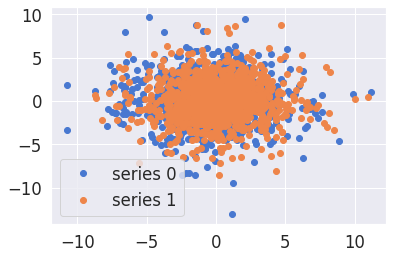

In [ ]:
import matplotlib.pyplot as plt
import skfuzzy as fuzz
cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(f-r, 2, 2, error=0.005, maxiter=1000)

# Show 3-cluster model
fig2,ax2 = plt.subplots()
for j in range(2):
    ax2.plot(f[0, u_orig.argmax(axis=0) == j],
             f[1, u_orig.argmax(axis=0) == j],'o',
             label='series ' + str(j))
ax2.legend()

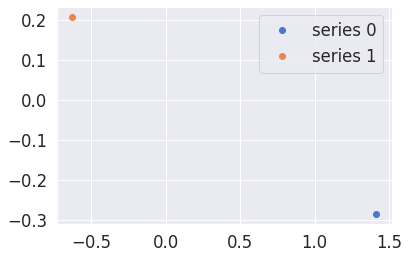

In [ ]:
cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(TSNE_1-TSNE_2, 2, 2, error=0.005, maxiter=1000)

# Show 3-cluster model
fig2,ax2 = plt.subplots()
for j in range(2):
    ax2.plot(TSNE_2[0, u_orig.argmax(axis=0) == j],
             TSNE_2[1, u_orig.argmax(axis=0) == j],'o',
             label='series ' + str(j))
ax2.legend()

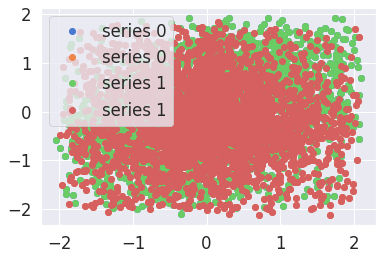

In [ ]:
fig,ax = plt.subplots()
for j in range(2):
    ax.plot(TSNE_1,
             TSNE_2,'o',
             label='series ' + str(j))
ax.legend()

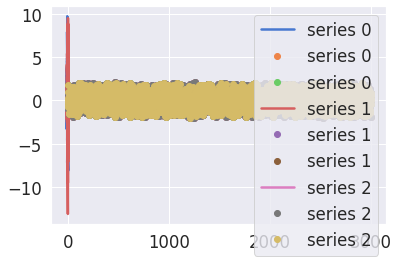

In [ ]:
cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(f-r, 2, 2, error=0.005, maxiter=1000)
fig,ax = plt.subplots()
for j in range(3):
    ax.plot(f[0, u_orig.argmax(axis=0) == j],
             f[1, u_orig.argmax(axis=0) == j],TSNE_1,'o',
             label='series ' + str(j))
ax.legend()

Inception score

In [ ]:
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
	# load inception v3 model
	model = InceptionV3()
	# enumerate splits of images/predictions
	scores = list()
	n_part = floor(images.shape[0] / n_split)
	for i in range(n_split):
		# retrieve images
		ix_start, ix_end = i * n_part, (i+1) * n_part
		subset = images[ix_start:ix_end]
		# convert from uint8 to float32
		subset = subset.astype('float32')
		# scale images to the required size
		subset = scale_images(subset, (299,299,3))
		# pre-process images, scale to [-1,1]
		subset = preprocess_input(subset)
		# predict p(y|x)
		p_yx = model.predict(subset)
		# calculate p(y)
		p_y = expand_dims(p_yx.mean(axis=0), 0)
		# calculate KL divergence using log probabilities
		kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
		# sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = mean(sum_kl_d)
		# undo the log
		is_score = exp(avg_kl_d)
		# store
		scores.append(is_score)
	# average across images
	is_avg, is_std = mean(scores), std(scores)
	return is_avg, is_std

#dataloader
imsize = BASE_SIZE * (2 ** (BRANCH_NUM - 1))
image_transform = transforms.Compose([
    transforms.Scale(int(imsize * 76 / 64)),
    transforms.RandomCrop(imsize),
    transforms.RandomHorizontalFlip()])
split_dir='test'
dataset = TextDataset(DATA_DIR, split_dir,
                      base_size=BASE_SIZE,
                      transform=image_transform)
assert dataset
# generate fake images
fimgs=[]
if NET_G == '':
            print('Error: the path for morels is not found!')
else:
    if split_dir == 'test':
        split_dir = 'valid'
    # Build /:and load the generator
    if B_DCGAN:
        netG = G_DCGAN()
    else:
        netG = G_NET()
    netG.apply(weights_init)
    netG.cuda()
    netG.eval()

    # load text encoder
    text_encoder = RNN_ENCODER(dataset.n_words, nhidden=EMBEDDING_DIM)
    state_dict = torch.load(NET_E, map_location=lambda storage, loc: storage)
    text_encoder.load_state_dict(state_dict)
    print('Load text encoder from:', NET_E)
    text_encoder = text_encoder.cuda()
    text_encoder.eval()

    #load image encoder
    image_encoder = CNN_ENCODER(EMBEDDING_DIM)
    img_encoder_path = NET_E.replace('text_encoder', 'image_encoder')
    state_dict = torch.load(img_encoder_path, map_location=lambda storage, loc: storage)
    image_encoder.load_state_dict(state_dict)
    print('Load image encoder from:', img_encoder_path)
    image_encoder = image_encoder.cuda()
    image_encoder.eval()

    batch_size = 10
    nz = 100
    noise = Variable(torch.FloatTensor(batch_size, nz), volatile=True)
    noise = noise.cuda()

    model_dir = NET_G
    state_dict = torch.load(model_dir, map_location=lambda storage, loc: storage)
    # state_dict = torch.load(NET_G)
    netG.load_state_dict(state_dict)
    print('Load G from: ', model_dir)
    bshuffle=True
    data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE,
    drop_last=True, shuffle=bshuffle, num_workers=int(WORKERS))
    cnt = 0
    cont = True
    for ii in range(11):  # (CAPTIONS_PER_IMAGE):
        if (cont == False):
            break
        for step, data in enumerate(data_loader, 0):
            cnt += batch_size
            if (cont == False):
                break
            if step % 100 == 0:
                print('cnt: ', cnt)

            imgs, captions, cap_lens, class_ids, keys = prepare_data(data)

            hidden = text_encoder.init_hidden(batch_size)
            # words_embs: batch_size x nef x seq_len
            # sent_emb: batch_size x nef
            words_embs, sent_emb = text_encoder(captions, cap_lens, hidden)
            words_embs, sent_emb = words_embs.detach(), sent_emb.detach()
            mask = (captions == 0)
            num_words = words_embs.size(2)
            if mask.size(1) > num_words:
                mask = mask[:, :num_words]

            #######################################################
            # (2) Generate fake images
            ######################################################
            noise.data.normal_(0, 1)
            fake_imgs, _, _, _ = netG(noise, sent_emb, words_embs, mask, cap_lens)
            for j in range(batch_size):
                k = -1
                im = fake_imgs[k][j].data.cpu().numpy()
                im = (im + 1.0) * 127.5
                im = im.astype(np.uint8)
                im = np.transpose(im, (1, 2, 0))
                fimgs.append(im)
               
                        
fimgs=np.array(fimgs)
shuffle(fimgs)
is_avg, is_std = calculate_inception_score(fimgs)
print('score', is_avg, is_std)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Total filenames:  11788 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg
/content/gdrive/My Drive/Saumya/birds/birds/test
Load filenames from: /content/gdrive/My Drive/Saumya/birds/birds/train/filenames.pickle (8855)
Load filenames from: /content/gdrive/My Drive/Saumya/birds/birds/test/filenames.pickle (2933)
Load from:  /content/gdrive/My Drive/Saumya/birds/birds/captions.pickle


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Load text encoder from: /content/gdrive/My Drive/Saumya/output/text_encoder200.pth
Load pretrained model from  https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth
Load image encoder from: /content/gdrive/My Drive/Saumya/output/image_encoder200.pth


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Load G from:  /content/gdrive/My Drive/Saumya/output/Model/DM-GAN/bird_DMGAN.pth
cnt:  10


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


cnt:  1010
cnt:  2010
cnt:  2940
cnt:  3940
cnt:  4940
cnt:  5870
cnt:  6870
cnt:  7870
cnt:  8800
cnt:  9800
cnt:  10800
cnt:  11730
cnt:  12730
cnt:  13730
cnt:  14660
cnt:  15660
cnt:  16660
cnt:  17590
cnt:  18590
cnt:  19590
cnt:  20520
cnt:  21520
cnt:  22520
cnt:  23450
cnt:  24450
cnt:  25450
cnt:  26380
cnt:  27380
cnt:  28380
cnt:  29310
cnt:  30310
cnt:  31310
score 5.672952 0.047423348
